In [5]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.dates as mdates
import media_mapper as mm
import psycopg2
from sqlalchemy import create_engine


MAPBOX_API_KEY not found.
TWITTER_CONSUMER_KEY not found.
TWITTER_CONSUMER_SECRET not found.
TWITTER_ACCESS_TOKEN not found.
TWITTER_TOKEN_SECRET not found.
INSTAGRAM_CLIENT_ID not found.
INSTAGRAM_CLIENT_SECRET not found.
INSTAGRAM_ACCESS_TOKEN not found.
FLICKR_API_KEY not found.
FLICKR_API_SECRET not found.


####Retrieve Data From Sql, as Well as Text. 

In [7]:
def retrieve_and_merge_tweet_data():
    '''Retrieves twitter geo data from SQL, and tweet text from the pickle object. 
    Returns the merged dataframe.'''
    #get SF Data From SQL
    df = mm.pipeline.retrieve_sql_tweets('tweets_with_geoV6')
    #get text data from picke
    dft = pd.read_pickle('data_pipeline/data/intermediate_data/tweettext_df.pickle')
    df = df.set_index('id')
    dft = dft.set_index('id')
    dfall = df.join(dft)
    return dfall

In [12]:
dfall =retrieve_and_merge_tweet_data()
#add a dates column to the timestamp
dfall = mm.pipeline.transform_timestamp(dfall).reset_index()
#add a count column to keep track of tweet number
dfall['tweet_cnt'] = 1

In [13]:
dfall.head()

,id,timestamp_ms,geoid10,text,time,date,tweet_cnt
0,621410300290592768,1436990735491,060750615003006,"I'm at @Google San Francisco in San Francisco,...",2015-07-15 20:05:35.491,2015-07-15,1
1,625416235082194944,1437945824772,060750134001000,Clear sky view of SF @ Alta Plaza Park https:/...,2015-07-26 21:23:44.772,2015-07-26,1
2,625816517381332992,1438041259509,060759804011003,http://t.co/aGnxhinfIM,2015-07-27 23:54:19.509,2015-07-27,1
3,625112776483188736,1437873474604,060750101001001,a gentleman's quarters at #Alcatraz \n\n#TheRo...,2015-07-26 01:17:54.604,2015-07-26,1
4,625345896507666432,1437929054749,060750604001007,"Спой, птичка, не стыдись... В #SanFrancisco_Zo...",2015-07-26 16:44:14.749,2015-07-26,1


In [48]:
def get_august_only(df):
    df['month'] = pd.DatetimeIndex(df.time).month
    dfaug = df[['month'] == 8]
    return dfaug

In [52]:
dfall['month'] = pd.DatetimeIndex(dfall.time).month
dfaug = dfall[dfall['month'] == 8]
dftime = dfall

 - <b>dftime</b>: all the dates
 - <b>dfaug</b>: just the newest ones with more dat    

##Question One: How Stable Are My Tweets?

###Group By the Hour Of Day

In [14]:
def tweets_hour(df, geo = True):
    '''Returns counts of tweets per hour. A DataFrame with Day of week, hour, ect marked.'''
    df['hour'] = pd.DatetimeIndex(df.time).hour
    if geo == True:
        df_rate = df.groupby(['date', 'hour', 'geoid10']).agg(np.sum)
    else:
        df_rate = df.groupby(['date', 'hour' ]).agg(np.sum)
    df_rate.drop('id', 1, inplace=True)
    df_rate = df_rate.reset_index()
    return df_rate

In [16]:
hr_df = tweets_hour(dfall)
#df_rate = megdf.groupby(['date', 'hour']).transf

In [17]:
hr_df.head()

,date,hour,geoid10,tweet_cnt
0,2015-07-15,5,060750103001011,1
1,2015-07-15,5,060750103001013,1
2,2015-07-15,5,060750105001024,2
3,2015-07-15,5,060750106002002,1
4,2015-07-15,5,060750106003007,1


###get counts of tweets per day

In [74]:
def tweets_per_day(df):
    '''Takes a dataframe. Determines the number of tweets logged in one day. 
    Also tabs the number of hours that tweets were gathered.'''
    df = df.groupby(['date', 'geoid10', 'hour']).agg(np.sum)
    df.insert(3, 'hr_marker', 1)
    df.reset_index(inplace = True)
    df = df.groupby(['date', 'geoid10']).agg(np.sum)
    df = df.reset_index()
    df['cnt/hr'] = df['tweet_cnt']/ df['hr_marker']
    df['dow'] = pd.DatetimeIndex(df.date).dayofweek

    return df

In [75]:
df_day  = tweets_per_day(dfaug)

####Quick Function to Make Scatterplots

In [58]:
def scatter_plot_it(df, x_col, y_col, title_data, x_label = None, y_label= None ,x_ticks = None):
    df.plot(x=x_col, y=y_col, kind = 'scatter', title = title_data )
    if x_label:
        plt.xlabel(x_label)
    if y_label:
        plt.ylabel(y_label)
    if x_ticks:
        plt.xticks(np.arange(x_ticks[0]), x_ticks[1])
    plt.show()

###Tweet Rate By Time of Day

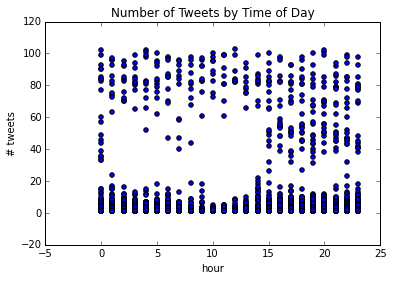

In [71]:
#Just August Data. Every GeoID. Total Number of tweets
scatter_plot_it(hr_df, 'hour', 'tweet_cnt', 'Number of Tweets by Time of Day', 'hour', '# tweets')

In [ ]:
scatter_plot_it(hr_df, 'hour', 'tweet_cnt', 'Number of Tweets by Time of Day', 'hour', '# tweets')

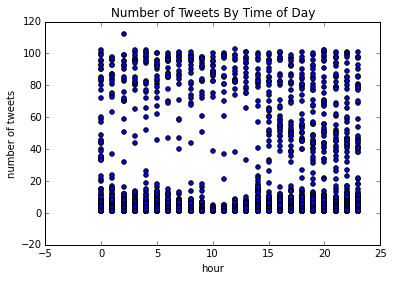

In [46]:
#All data. Every GeoID. Total Number of tweets
scatter_plot_it(hr_df, 'hour', 'tweet_cnt', 'Number of Tweets By Time of Day', 'hour', 'number of tweets')

###Tweet Rate by Day Of Week

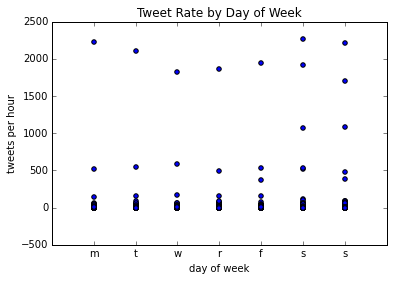

In [77]:
#all geoids, all dates, how did thier twet rate vary by day of week?
scatter_plot_it(df_day, 'dow', 'tweet_cnt', 'Tweet Rate by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))

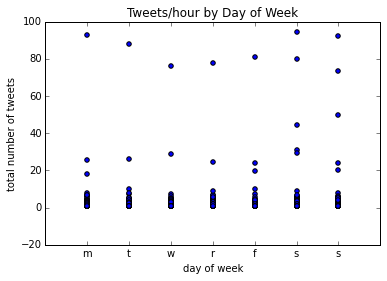

In [100]:
scatter_plot_it(df_day, 'dow', 'cnt/hr', 'Tweets/hour by Day of Week',\
                x_label="day of week", y_label ='total number of tweets', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))

#What is the Spread of Tweet Count Across Neighborhoods

###The Twenty Most Active Blocks

In [105]:
twtcnt_and_geo = hr_df[['geoid10', 'tweet_cnt', 'hour']]

In [113]:
top_neighborhoods = hr_df[['geoid10', 'tweet_cnt']].groupby(['geoid10']).agg(np.sum).reset_index().sort(columns='tweet_cnt',ascending = False )

In [185]:
top_neighbs = top_neighborhoods[:50]['geoid10'].tolist()
top_neighbs

['060759804011003',
 '060750201001001',
 '060759803001030',
 '060750122011000',
 '060750117002025',
 '060750130002000',
 '060750332011005',
 '060750101001001',
 '060750105001024',
 '060750124022019',
 '060750105002001',
 '060750129023005',
 '060750601001021',
 '060750615001040',
 '060750126022000',
 '060750177002001',
 '060750601001016',
 '060750123011004',
 '060750176011005',
 '060750128001013',
 '060750101001004',
 '060750615001032',
 '060750607001001',
 '060759803001054',
 '060750176011001',
 '060750176014001',
 '060750206004002',
 '060750615001050',
 '060750601001011',
 '060750166001001',
 '060750178022012',
 '060759802001001',
 '060750105002014',
 '060750110003006',
 '060750124022016',
 '060750601001002',
 '060750479012003',
 '060750164001000',
 '060750206001009',
 '060750121001001',
 '060759804011000',
 '060750601001000',
 '060750102003000',
 '060750202003000',
 '060750205001009',
 '060750201001009',
 '060750124022008',
 '060750105001001',
 '060750201001002',
 '060750155001004']

###What is the Hourly Activity for the Twenty most Tweeting Blocks?

In [116]:
hourly_activity = twtcnt_and_geo.groupby(['geoid10', 'hour']).agg(np.sum).reset_index().sort(columns = 'tweet_cnt', ascending = False)

In [122]:
hourly_activity.head()

,geoid10,hour,tweet_cnt
13169,060759804011003,0,797
13179,060759804011003,10,795
13173,060759804011003,4,795
13181,060759804011003,12,788
13175,060759804011003,6,782


In [128]:
tophourly_activity = hourly_activity[hourly_activity['geoid10'].isin(top_neighbs)]

In [181]:
tophourly_activity.head()

,geoid10,hour,tweet_cnt
13169,060759804011003,0,797
13179,060759804011003,10,795
13173,060759804011003,4,795
13181,060759804011003,12,788
13175,060759804011003,6,782


###Interesting. Some are Highly cyclical, and other are not. 

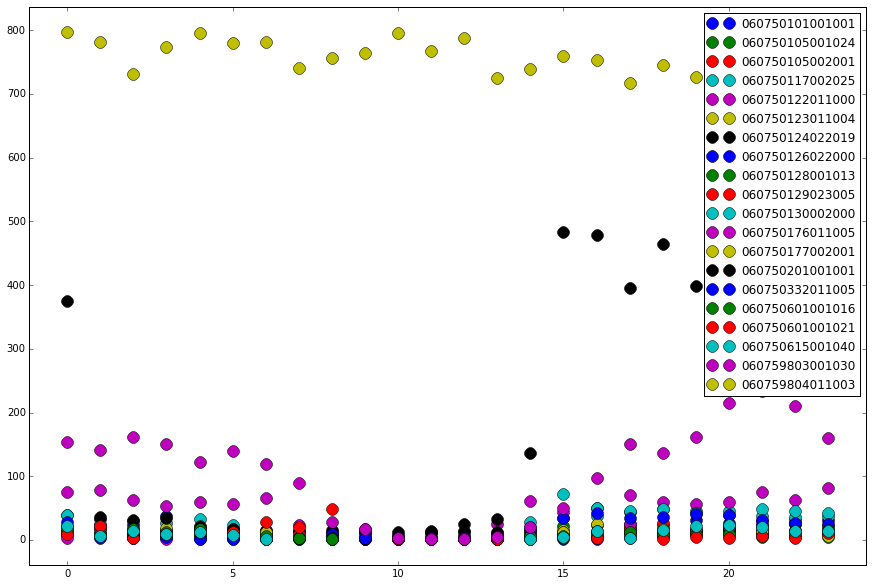

In [184]:
def plot_neighborhoods(df=tophourly_activity, column_labels='geoid10', x_colname ='hour', y_colname ='tweet_cnt'):
    groups = df.groupby(column_labels)
    # Plot
    fig, ax = plt.subplots()
    fig.set_figwidth(15)
    fig.set_figheight(10)
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group[x_colname], group[y_colname], marker='o', linestyle='', ms=12, label=name)
    ax.legend()
    
    plt.show()
plot_neighborhoods()   

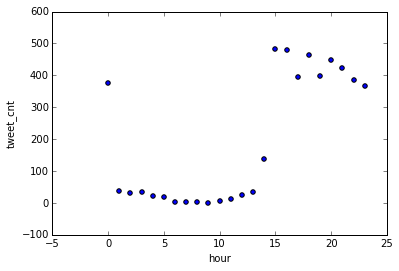

In [162]:
tophourly_activity[tophourly_activity['geoid10'] == '060750201001001'].plot(x = 'hour', y = 'tweet_cnt', kind = 'scatter')

###Tweet Rate by Date

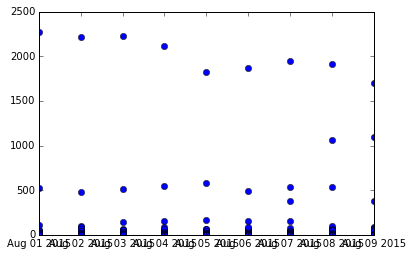

In [102]:
plt.plot_date(x=df_day['date'], y=df_day['tweet_cnt'])
plt.show()

###Includes June Data, Which Has Less Extraction

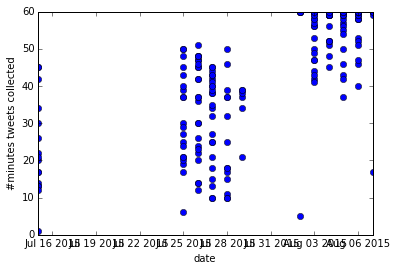

In [384]:
plt.plot_date(x=min_df['date'], y=min_df['min_count'])
plt.xlabel('date')
plt.ylabel('#minutes tweets collected')
plt.show()

In [ ]:
plt.scatter(x, y, c=y, s=500)
plt.gray()

plt.show()

In [388]:
dates = min_df.date.unique()

In [401]:
len(dates)

12

##New Question:
###Are All Neighborhoods Consistent by Day?


In [457]:
def tweets_per_min_Geo(df):
    '''Returns counts of tweets per hour, but KEEPS geodata.'''
    #df['min']= pd.DatetimeIndex(df["times"]).minute
    df_rate = df.groupby(['geoid10','date', 'hour', 'min']).agg(np.sum)
    df_rate.insert(1, 'min_count', 1)
    df_rate = df_rate.reset_index()
    df_rate.drop('timestamp_ms', 1, inplace=True)
    df_rate.drop('DOW', 1, inplace=True)
    df_rate =df_rate.groupby(['geoid10','date', 'hour']).agg(np.sum)
    df_rate= df_rate.reset_index()
    #the rate of tweets is determined by the sum of tweets divided by the number of minutes observed
    df_rate['t_p_min']= df_rate['count']/df_rate['min_count']
  
    return df_rate

###Activity by time in Popular Areas

In [40]:
##An event happened this weekend at golden gate park:
goldengate = ['060759803001030','060759803001065','060759803001032','060759803001017']
ferrybuilding = ['060750105002001']
dolores = ['060750206001004','060750206001009']

###goldengate park had an event 

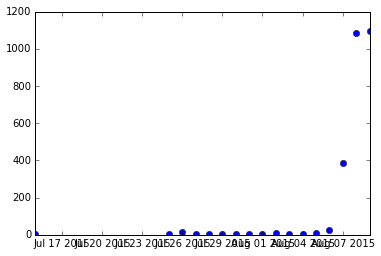

In [37]:
goldengate_time = hr_df[hr_df['geoid10'].isin(goldengate)]
dailycnt_goldengate = goldengate_time.groupby('date').agg(sum)
plt.plot_date(x=dailycnt_goldengate.index, y=dailycnt_goldengate['tweet_cnt'])
plt.show()

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


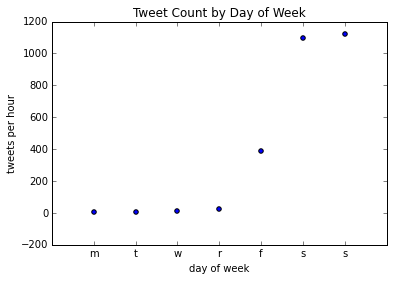

In [62]:
goldengate_time = hr_df[hr_df['geoid10'].isin(goldengate)]
goldengate_time['dow'] = pd.DatetimeIndex(goldengate_time.date).dayofweek
goldengate_time = goldengate_time.groupby('dow').agg(sum).reset_index()
scatter_plot_it(goldengate_time, 'dow', 'tweet_cnt', 'Tweet Count by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))


###Ferry Building

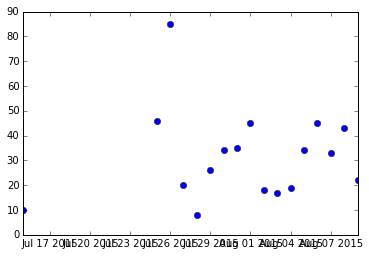

In [41]:
ferry_time = hr_df[hr_df['geoid10'].isin(ferrybuilding)]
ferry_time = ferry_time.groupby('date').agg(sum)
plt.plot_date(x=ferry_time.index, y=ferry_time['tweet_cnt'])
plt.show()

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


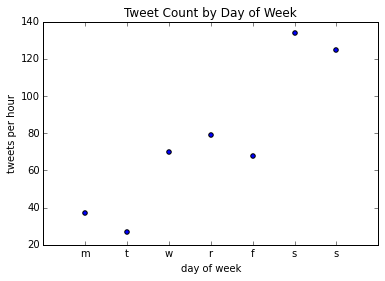

In [61]:
ferry_time = hr_df[hr_df['geoid10'].isin(ferrybuilding)]
ferry_time['dow'] = pd.DatetimeIndex(ferry_time.date).dayofweek
ferry_time = ferry_time.groupby('dow').agg(sum).reset_index()
scatter_plot_it(ferry_time, 'dow', 'tweet_cnt', 'Tweet Count by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))


/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


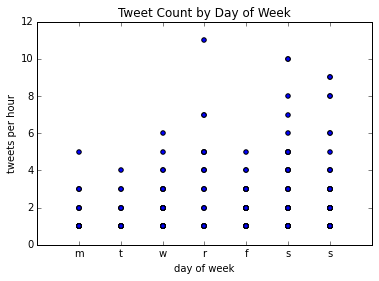

In [66]:
ferry_time = hr_df[hr_df['geoid10'].isin(ferrybuilding)]
ferry_time['dow'] = pd.DatetimeIndex(ferry_time.date).dayofweek
scatter_plot_it(ferry_time, 'dow', 'tweet_cnt', 'Tweet Count by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))

###Dolores Park

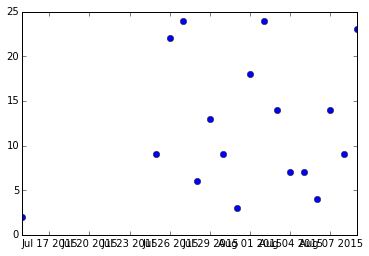

In [43]:
doloresdf = hr_df[hr_df['geoid10'].isin(dolores)]
doloresdf = doloresdf.groupby('date').agg(sum)
plt.plot_date(x=doloresdf.index, y=doloresdf['tweet_cnt'])
plt.show()

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


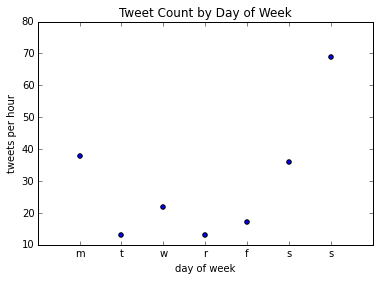

In [63]:
doloresdf = hr_df[hr_df['geoid10'].isin(dolores)]
doloresdf['dow'] = pd.DatetimeIndex(doloresdf.date).dayofweek
doloresdf = doloresdf.groupby('dow').agg(sum).reset_index()
scatter_plot_it(doloresdf, 'dow', 'tweet_cnt', 'Tweet Count by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))

/Users/christy/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


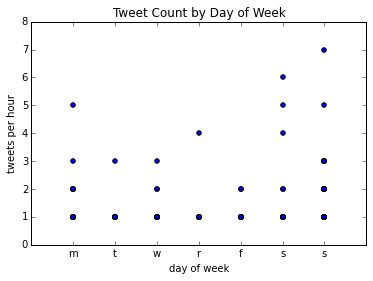

In [64]:
doloresdf = hr_df[hr_df['geoid10'].isin(dolores)]
doloresdf['dow'] = pd.DatetimeIndex(doloresdf.date).dayofweek
scatter_plot_it(doloresdf, 'dow', 'tweet_cnt', 'Tweet Count by Day of Week',\
                x_label="day of week", y_label ='tweets per hour', \
                x_ticks = (7, ('m', 't', 'w', 'r', 'f', 's', 's')))